# AIAp Miniproject 2

## Contents

- [Imports](#imports)

## Imports

In [134]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from sklearn import utils as sk_utils
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import utils as keras_utils
from tensorflow.keras import models as keras_models
from tensorflow.keras import layers as keras_layers
from tensorflow.keras import regularizers as keras_regularizers

## Configs

In [135]:
SEED = 42

## Dataset

### b) Citation and description

For our project we used the following data:

- **Title:** Architectural Heritage Elements Dataset
- **Subtitle:** 128 (creative commons) revised
- **Version:** 1
- **Publication Date:** 2017-02-20
- **Author:** Jose Llamas
- **Organization:** Fundación CARTIF
- **Source:** https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Architectural_Heritage_Elements_Dataset_128%28creative_commons%29.zip
- **Media:** .jpg in .zip
- **Download:** 2024-03-26

The raw data was extracted with Windows. We then added it to our ["AIAp Miniproject 2"](https://gitlab.ost.ch/sylvester.homberger/aiap-miniproject-2) repository on the Gitlab instance of OST.

This dataset consists of 10437 RGB 64x64 jpg images classified in 11 categories:
- Altar: 828 images
- Apse: 505 images
- Bell tower: 1057 images
- Column: 1914 images
- Dome (inner): 589 images
- Dome (outer): 1175 images
- Flying buttress: 405 images
- Gargoyle (and Chimera): 1562 images
- Portal: 307 images
- Stained glass: 998 images
- Vault: 1097 images

As "flying buttress" and "portal" do not satisfy the minimal samples requirement of 500, we manually moved them out of our dataset into a separate folder. Our adjusted dataset therefore fulfils the requirements:
- RGB images of 9 classes
- Each has more than 500 samples and the total is 9725 images
- They have a resolution of 64x64 pixels

### c) Load and split data

In [136]:
data_folder = Path(os.getcwd()).parent / "data"
raw_folder = data_folder / "raw" / "Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised"

raw_train_val_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="training"
)

raw_test_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="validation"
)

raw_training_data, raw_validation_data = keras_utils.split_dataset(raw_train_val_data, left_size=0.8, shuffle=True)

classes = raw_train_val_data.class_names

Found 9725 files belonging to 9 classes.
Using 6808 files for training.
Found 9725 files belonging to 9 classes.
Using 2917 files for validation.


## Exploratory data analysis

### Plot a few images

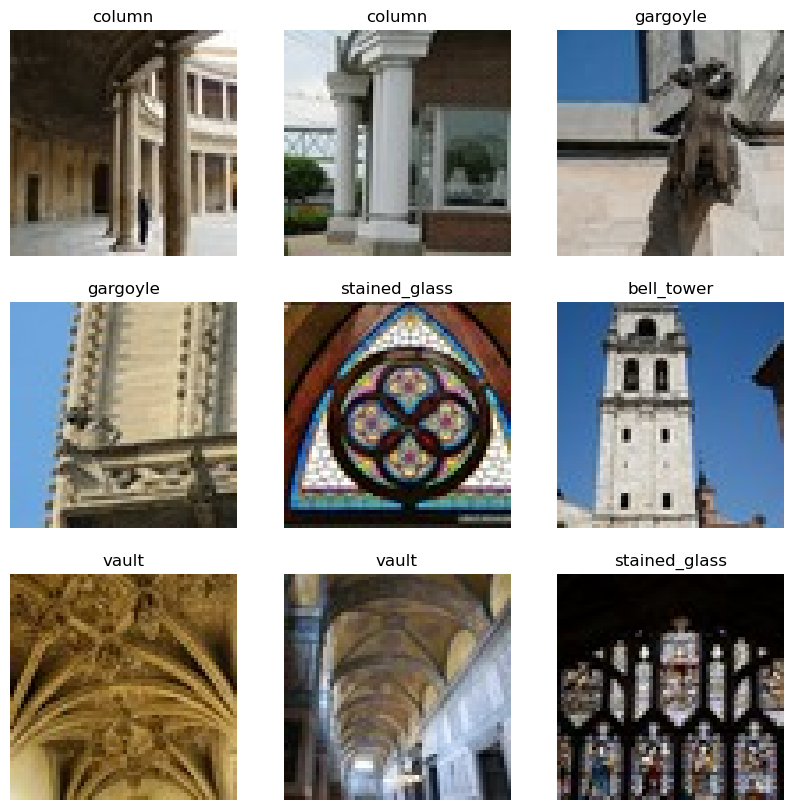

In [137]:
def show_pictures(data=raw_train_val_data):
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1):
      for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")
show_pictures()

### Samples per class

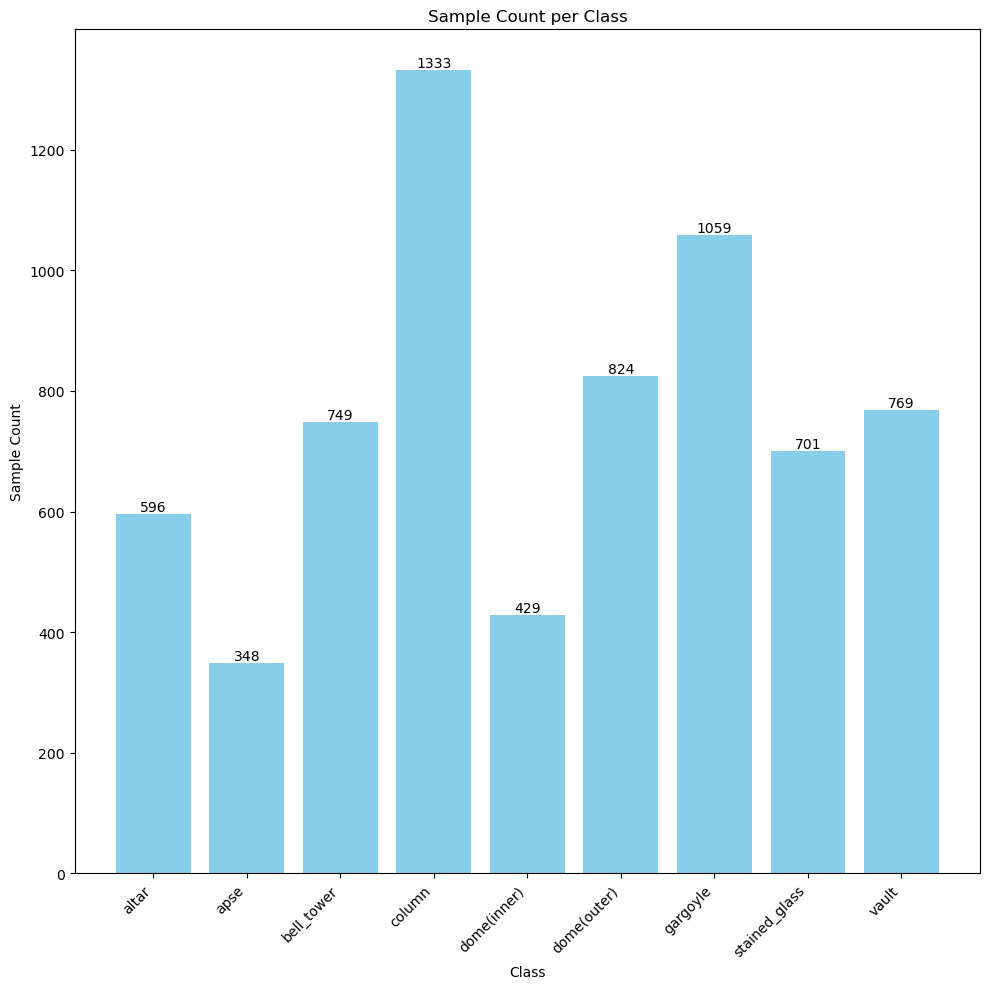

In [138]:
# Count samples per class
class_counts = raw_train_val_data.reduce(
    initial_state=tf.zeros(len(classes), dtype=tf.int32),
    reduce_func=lambda count, images_labels: count + tf.math.bincount(images_labels[1], minlength=len(classes)))

# Extract numbers
class_counts_values = [count.numpy() for count in class_counts]

# Plot samples per class
plt.figure(figsize=(10, 10))
bars = plt.bar(classes, class_counts_values, color='skyblue')
plt.bar_label(bars, labels=class_counts_values, label_type='edge', color='black')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.title('Sample Count per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


The dataset is not balanced. Classes need to be weighted for training.

### Distribution of values

Red range: 	 0.0  -  255.0
Green range: 	 0.0  -  255.0
Blue range: 	 0.0  -  255.0


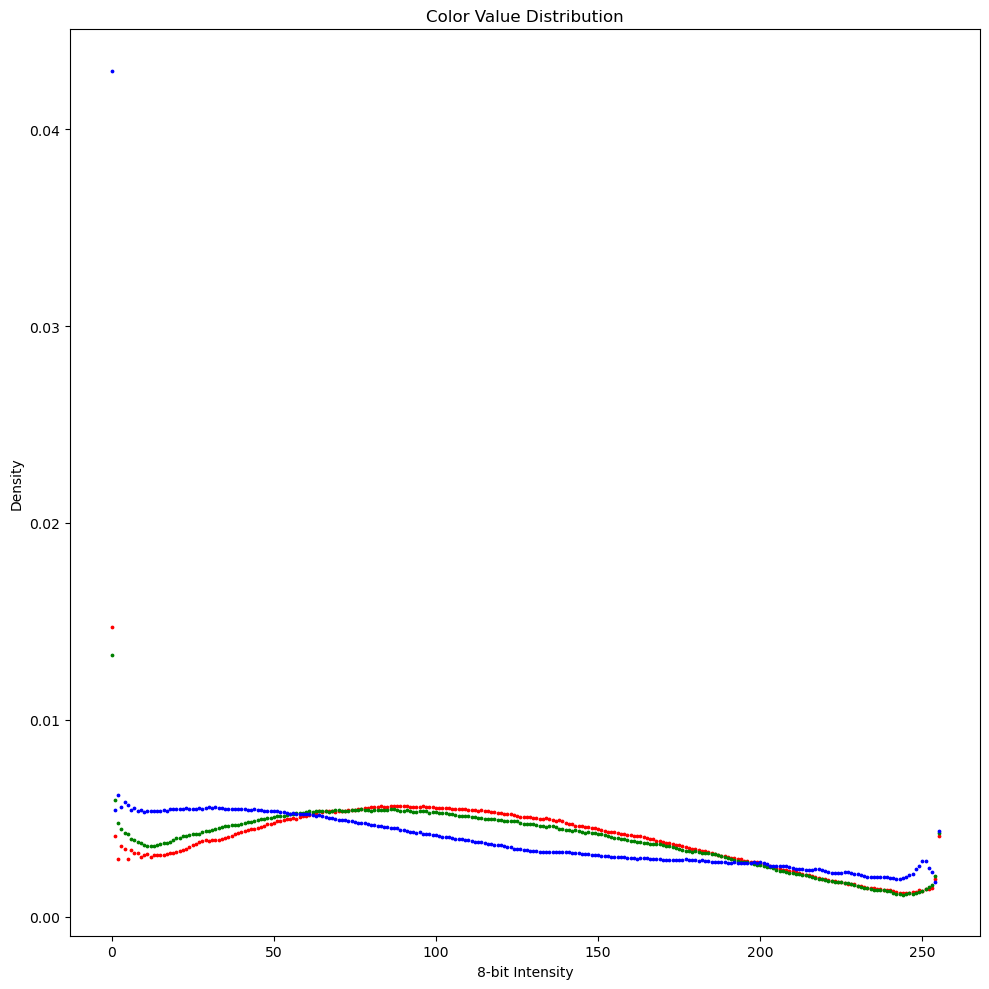

In [139]:
# Concatenate all images in the dataset
images_np = np.concatenate([images.numpy() for images, _ in raw_training_data])

# Reshape to (num_images * height * width, channels)
images_np = images_np.reshape(-1, images_np.shape[3])

# Extract RGB values
red_values = images_np[:, 0]
green_values = images_np[:, 1]
blue_values = images_np[:, 2]

# Get range of values
red_max = np.max(red_values)
red_min = np.min(red_values)
print("Red range: \t", red_min, " - ", red_max)
green_max = np.max(green_values)
green_min = np.min(green_values)
print("Green range: \t", green_min, " - ", green_max)
blue_max = np.max(blue_values)
blue_min = np.min(blue_values)
print("Blue range: \t", blue_min, " - ", blue_max)

# Calculate the distribution
red_distribution = np.histogram(red_values, bins=256, density=True)[0]
green_distribution = np.histogram(green_values, bins=256, density=True)[0]
blue_distribution = np.histogram(blue_values, bins=256, density=True)[0]

# Plot all color densities on the same plot
plt.figure(figsize=(10, 10))
plt.scatter(range(len(red_distribution)), red_distribution, color='red', s=3)
plt.scatter(range(len(green_distribution)), green_distribution, color='green', s=3)
plt.scatter(range(len(blue_distribution)), blue_distribution, color='blue', s=3)
plt.xlabel('8-bit Intensity')
plt.ylabel('Density')
plt.title('Color Value Distribution')
plt.tight_layout()

We observe significant peaks at the extreme ends of the value range (0 and 255). The underlying cause is unclear to us, as we did not generate the images ourselves. 

We observed a clear distinction in the distribution of blue intensity compared to that of red and green. While all colors demonstrate a decrease in density as intensity increases, there are notable variations among them. Specifically, red and green intensities seem to follow a somewhat normal distribution pattern, whereas blue intensity exhibits a nearly monotonic decline.

This decrease in density across intensities could potentially stem from heightened sensitivity of the camera equipment at higher levels, leading to a stretched scale. However, when examining the discrepancy between blue and the other colors, our initial online investigation did not provide immediate insights into the underlying cause of this disparity.

However, those phenomenona should not hinder meaningful model training, provided it does not systematically convey information regarding the classes.

Additionally, we need to rescale the value range from [0 - 255] to [0 - 1]. The below function will also be used for the test data later.

### Required adjustments from result of analysis

#### Scale images

In [140]:
def scale_image_dataset(dataset):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return dataset.map(lambda x, y: (normalization_layer(x), y))

training_data = scale_image_dataset(raw_training_data)
validation_data = scale_image_dataset(raw_validation_data)

#### labels in numpy arrays

In [141]:
def get_labels(data):
    true_labels = []
    for f, l in data:
        true_labels.extend(l.numpy())
    return np.array(true_labels)

def get_predicted_labels(model, data):
    predictions = model.predict(data)
    return np.array(np.argmax(predictions, axis=1))

#### Calculate class weights

In [142]:
def generate_class_weights(t_data=training_data):
    # create list of all labels
    y_train = get_labels(t_data)
    # Calculate class weights
    class_weights = sk_utils.class_weight.compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train),
        y=y_train
    )
    # Convert class weights to a dictionary format
    return dict(zip(np.unique(y_train), class_weights))

## Architecture (common functions)

#### Compile and train function

In [143]:
def compile_and_train(model, epochs=50, t_data=training_data, v_data=validation_data):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model.fit(t_data, validation_data=v_data, epochs=epochs, class_weight=generate_class_weights())

#### visualize accuracy and loss function

In [144]:
def visualize_model(history, plot_title):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(accuracy))
    
    plt.figure(figsize=(10, 5))
    plt.suptitle(plot_title, fontsize='x-large')
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

#### visualize the confusion matrix

In [145]:
def calculate_confusion_matrix(model, v_data=validation_data, normalize=None):
    true_labels = get_labels(v_data)
    predicted_labels = get_predicted_labels(model, v_data)
    return sk_metrics.confusion_matrix(true_labels, predicted_labels, normalize=normalize)

def visualize_confusion_matrix(confusion_matrix, color_map='Blues'):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap(color_map))
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Display the counts in each cell
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Architecture 1 (underfitting)

#### Model

In [146]:
underfitting_model = keras_models.Sequential()
underfitting_model.add(keras_layers.Conv2D(
    filters=4, kernel_size=3, padding='same', activation='relu', input_shape=(64, 64, 3)
))
underfitting_model.add(keras_layers.MaxPooling2D())
underfitting_model.add(keras_layers.Conv2D(
    filters=4, kernel_size=9, strides=4, padding='same', activation='relu'
))
underfitting_model.add(keras_layers.MaxPooling2D())
underfitting_model.add(keras_layers.Flatten())
underfitting_model.add(keras_layers.Dense(len(classes)))

#### Summary

In [147]:
underfitting_model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 32, 32, 4)        0         
 ng2D)                                                           
                                                                 
 conv2d_124 (Conv2D)         (None, 8, 8, 4)           1300      
                                                                 
 max_pooling2d_121 (MaxPooli  (None, 4, 4, 4)          0         
 ng2D)                                                           
                                                                 
 flatten_42 (Flatten)        (None, 64)                0         
                                                                 
 dense_81 (Dense)            (None, 9)               

### Compile and train the model

In [148]:
underfitting_history = compile_and_train(model=underfitting_model)

Epoch 1/50
171/171 [==============================] - 2s 8ms/step - loss: 2.0843 - accuracy: 0.1866 - val_loss: 1.9430 - val_accuracy: 0.2548
Epoch 2/50
171/171 [==============================] - 1s 8ms/step - loss: 1.8034 - accuracy: 0.3021 - val_loss: 1.6156 - val_accuracy: 0.3811
Epoch 3/50
171/171 [==============================] - 1s 8ms/step - loss: 1.5715 - accuracy: 0.3803 - val_loss: 1.5330 - val_accuracy: 0.4207
Epoch 4/50
171/171 [==============================] - 1s 8ms/step - loss: 1.4990 - accuracy: 0.4067 - val_loss: 1.4915 - val_accuracy: 0.4567
Epoch 5/50
171/171 [==============================] - 1s 8ms/step - loss: 1.4535 - accuracy: 0.4262 - val_loss: 1.4647 - val_accuracy: 0.4677
Epoch 6/50
171/171 [==============================] - 2s 9ms/step - loss: 1.4190 - accuracy: 0.4401 - val_loss: 1.4397 - val_accuracy: 0.4772
Epoch 7/50
171/171 [==============================] - 1s 8ms/step - loss: 1.3896 - accuracy: 0.4510 - val_loss: 1.4154 - val_accuracy: 0.4824
Epoch 

### Visualize training results

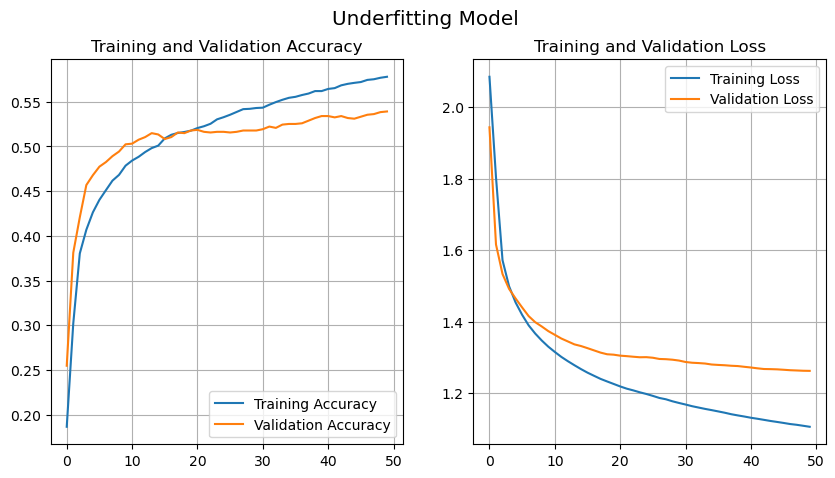

In [149]:
visualize_model(underfitting_history, 'Underfitting Model')

### Confusion Matrix

#### Confusion Matrix with "true" normalization

43/43 [==============================] - 0s 3ms/step


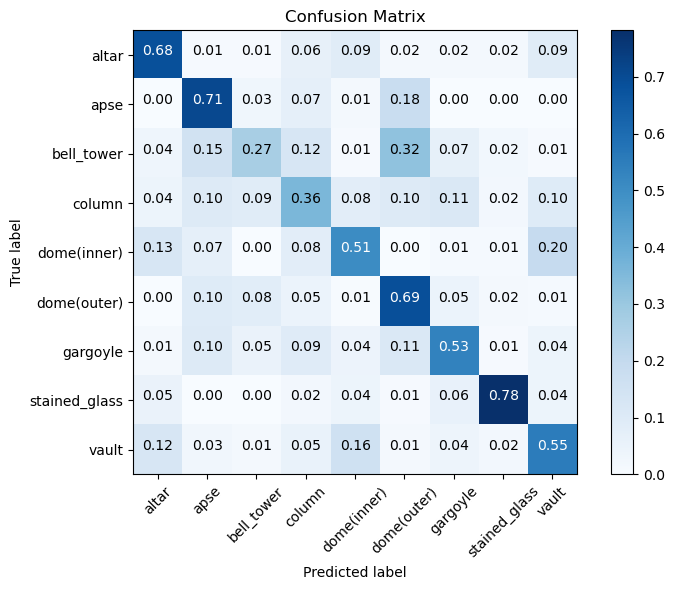

In [150]:
conf_matrix = calculate_confusion_matrix(underfitting_model,validation_data, "true")
visualize_confusion_matrix(conf_matrix, color_map='Blues')

#### Confusion Matrix with "pred" normalization

43/43 [==============================] - 0s 5ms/step


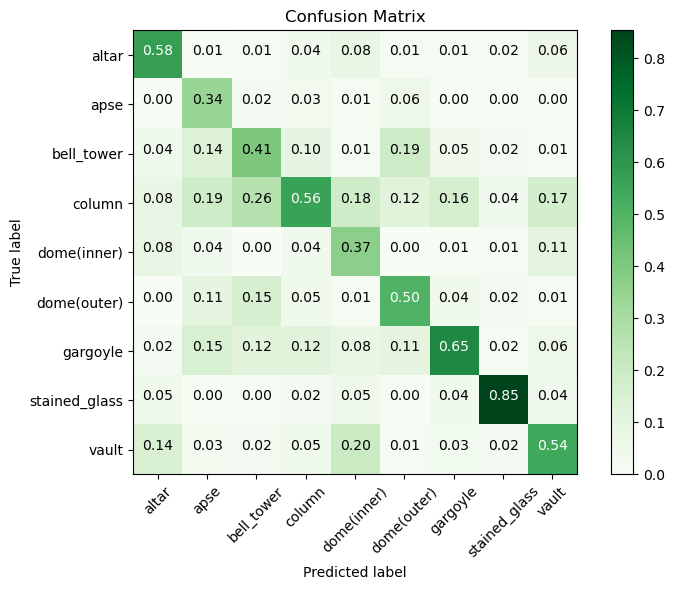

In [151]:
conf_matrix = calculate_confusion_matrix(underfitting_model,validation_data, "pred")
visualize_confusion_matrix(conf_matrix, color_map='Greens')

#### Confusion Matrix with "all" normalization

43/43 [==============================] - 0s 4ms/step


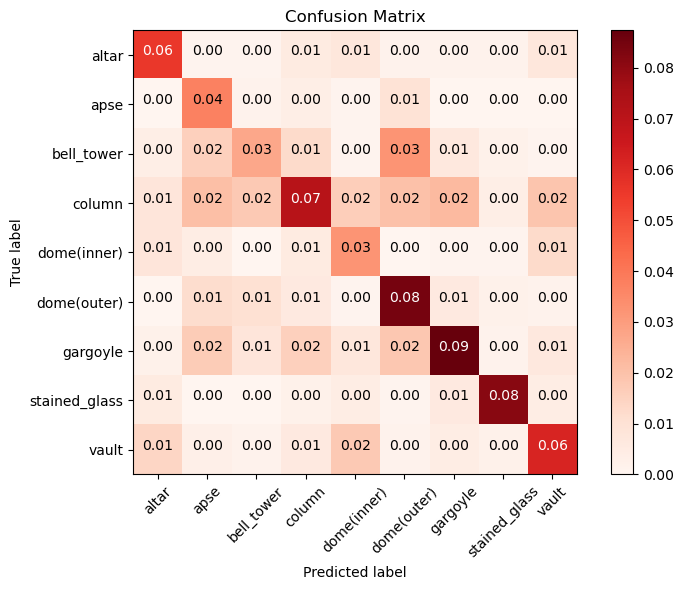

In [152]:
conf_matrix = calculate_confusion_matrix(underfitting_model,validation_data, "all")
visualize_confusion_matrix(conf_matrix, color_map='Reds')

### Discussion

As required by the assignment, there are 3 trainable layers and the 1997 trainable parameters which are below the maximum of about 2000. We added stride to one layer and used multiple MaxPooling to decrease the number of parameters. The stride of 4 is below the kernel size of 9. This is important, because if it was higher, whole columns / rows of the input to such a layer would be lost to the network. The stride would move further than the kernel size can cover.

The training history for accuracy and loss evolve typically for underfitting models. That is they stay close together for training and validation data. The validation loss does not explode. Additionally the accuracy stays below the two more complex models of architecture 2. We therefore conclude that we observe underfitting.

_**TODO:**_ Add guesstimates for accuracy / loss







## Architecture 2 (overfitting)

### Model

In [153]:
overfitting_model = keras_models.Sequential()
overfitting_model.add(keras_layers.Conv2D(
    filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(64, 64, 3)
))
overfitting_model.add(keras_layers.MaxPooling2D())
overfitting_model.add(keras_layers.Conv2D(
    filters=32, kernel_size=5, padding='same', activation='relu'
))
overfitting_model.add(keras_layers.MaxPooling2D())
overfitting_model.add(keras_layers.Conv2D(
    filters=64, kernel_size=7, padding='same', activation='relu'
))
overfitting_model.add(keras_layers.Flatten())
overfitting_model.add(keras_layers.Dense(81))
overfitting_model.add(keras_layers.Dense(len(classes)))

### Summary

In [154]:
overfitting_model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_122 (MaxPooli  (None, 32, 32, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 32, 32, 32)        12832     
                                                                 
 max_pooling2d_123 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_127 (Conv2D)         (None, 16, 16, 64)        100416    
                                                                 
 flatten_43 (Flatten)        (None, 16384)           

### Compile and train the model

In [155]:
overfitting_history = compile_and_train(overfitting_model)

Epoch 1/50
171/171 [==============================] - 8s 48ms/step - loss: 1.5815 - accuracy: 0.3795 - val_loss: 1.3034 - val_accuracy: 0.5264
Epoch 2/50
171/171 [==============================] - 8s 48ms/step - loss: 1.1328 - accuracy: 0.5793 - val_loss: 1.1668 - val_accuracy: 0.6065
Epoch 3/50
171/171 [==============================] - 8s 46ms/step - loss: 0.8857 - accuracy: 0.6667 - val_loss: 0.9462 - val_accuracy: 0.6659
Epoch 4/50
171/171 [==============================] - 8s 45ms/step - loss: 0.7166 - accuracy: 0.7332 - val_loss: 0.9946 - val_accuracy: 0.6645
Epoch 5/50
171/171 [==============================] - 8s 46ms/step - loss: 0.5669 - accuracy: 0.7842 - val_loss: 0.9500 - val_accuracy: 0.6982
Epoch 6/50
171/171 [==============================] - 8s 45ms/step - loss: 0.4214 - accuracy: 0.8410 - val_loss: 0.8802 - val_accuracy: 0.7298
Epoch 7/50
171/171 [==============================] - 8s 44ms/step - loss: 0.3629 - accuracy: 0.8564 - val_loss: 0.9111 - val_accuracy: 0.7232

### Visualize training results

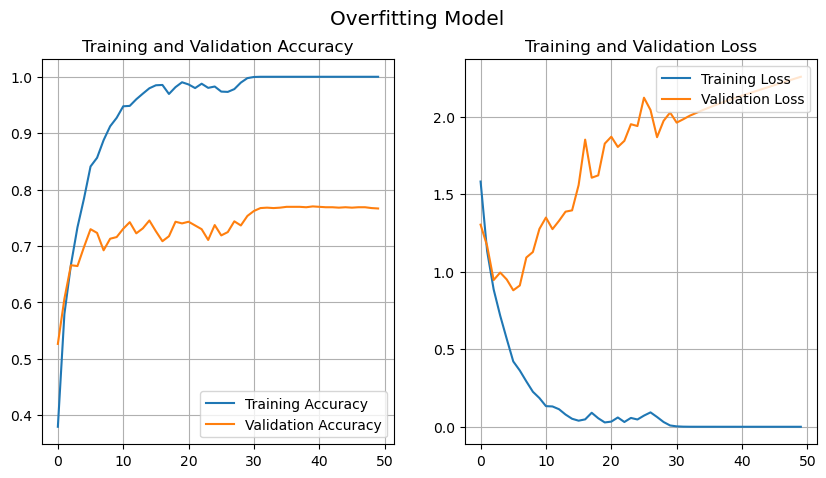

In [156]:
visualize_model(overfitting_history, 'Overfitting Model')

### Confusion Matrix

#### Confusion Matrix with "true" normalization

43/43 [==============================] - 1s 16ms/step


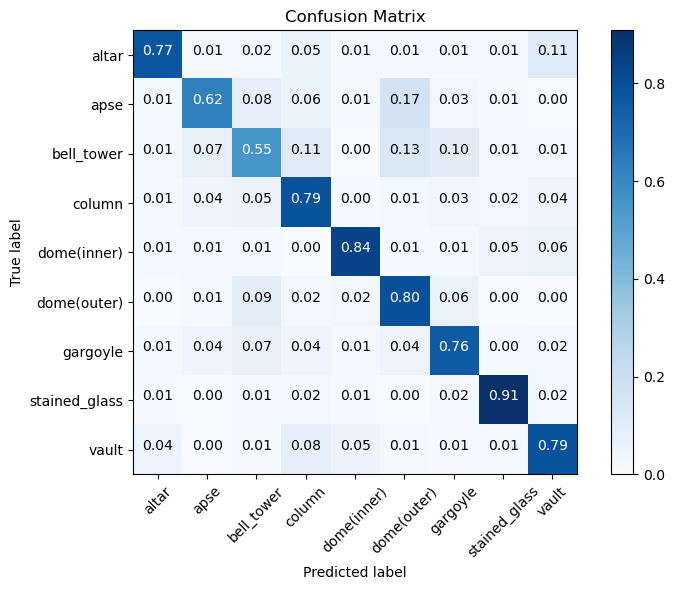

In [157]:
conf_matrix = calculate_confusion_matrix(overfitting_model,validation_data, "true")
visualize_confusion_matrix(conf_matrix, color_map='Blues')

#### Confusion Matrix with "pred" normalization

43/43 [==============================] - 1s 14ms/step


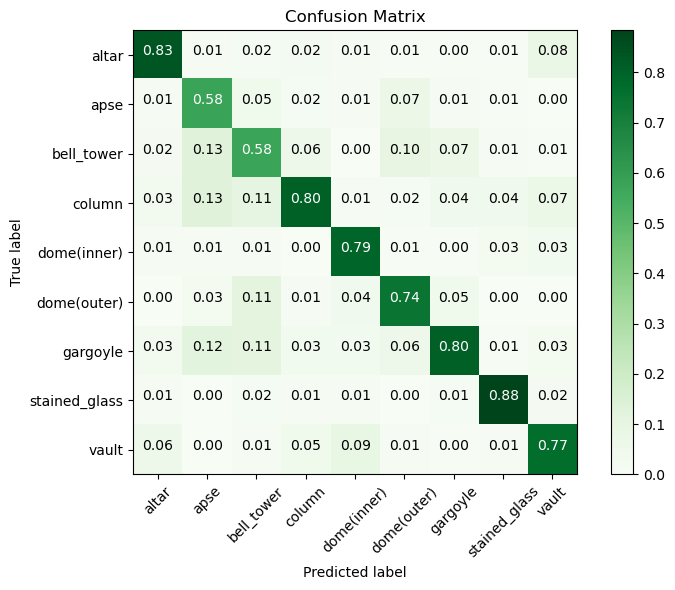

In [158]:
conf_matrix = calculate_confusion_matrix(overfitting_model,validation_data, "pred")
visualize_confusion_matrix(conf_matrix, color_map='Greens')

#### Confusion Matrix with "all" normalization

43/43 [==============================] - 1s 17ms/step


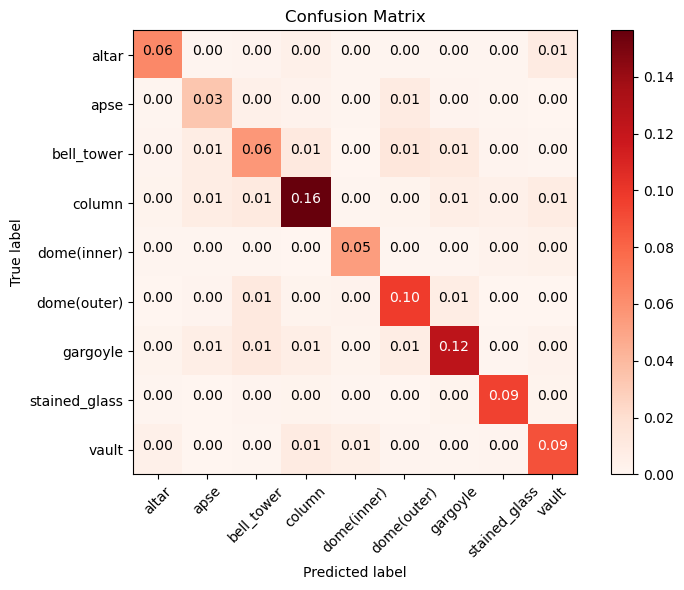

In [159]:
conf_matrix = calculate_confusion_matrix(overfitting_model,validation_data, "all")
visualize_confusion_matrix(conf_matrix, color_map='Reds')

### Discussion

## Architecture 2 (optimized)

### Model

#### Regularization Terms

In [160]:
# Low regularization
low_dropout_rate = 0.1
low_l2_lambda = 10**-6
# Optimized regularization
optimized_dropout_rate = 0.5
optimized_l2_lambda = 10**-3
# High regularization
high_dropout_rate = 0.65
high_l2_lambda = 10**-2

In [161]:
def get_optimized_model(dropout_rate, l2_lambda):
    model = keras_models.Sequential()
    model.add(keras_layers.Conv2D(
        filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=keras_regularizers.l2(l2_lambda), input_shape=(64, 64, 3)
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Dropout(rate=dropout_rate))
    model.add(keras_layers.Conv2D(
        filters=32, kernel_size=5, padding='same', activation='relu', kernel_regularizer=keras_regularizers.l2(l2_lambda)
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Dropout(rate=dropout_rate))
    model.add(keras_layers.Conv2D(
        filters=64, kernel_size=7, padding='same', activation='relu', kernel_regularizer=keras_regularizers.l2(l2_lambda)
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Dropout(rate=dropout_rate))
    model.add(keras_layers.Flatten())
    model.add(keras_layers.Dense(81))
    model.add(keras_layers.Dropout(rate=dropout_rate))
    model.add(keras_layers.Dense(len(classes)))
    return model

optimized_low_model = get_optimized_model(low_dropout_rate, low_l2_lambda)
optimized_model = get_optimized_model(optimized_dropout_rate, optimized_l2_lambda)
optimized_high_model = get_optimized_model(high_dropout_rate, high_l2_lambda)

### Summary

In [162]:
optimized_model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_131 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_127 (MaxPooli  (None, 32, 32, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_148 (Dropout)       (None, 32, 32, 16)        0         
                                                                 
 conv2d_132 (Conv2D)         (None, 32, 32, 32)        12832     
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_149 (Dropout)       (None, 16, 16, 32)      

### Compile and train the model

In [163]:
optimized_low_history = compile_and_train(optimized_low_model)
optimized_history = compile_and_train(optimized_model)
optimized_high_history = compile_and_train(optimized_high_model)

Epoch 1/50
171/171 [==============================] - 9s 50ms/step - loss: 1.4979 - accuracy: 0.4181 - val_loss: 1.2739 - val_accuracy: 0.5536
Epoch 2/50
171/171 [==============================] - 8s 47ms/step - loss: 1.0788 - accuracy: 0.6012 - val_loss: 1.0375 - val_accuracy: 0.6336
Epoch 3/50
171/171 [==============================] - 8s 46ms/step - loss: 0.8814 - accuracy: 0.6697 - val_loss: 0.9111 - val_accuracy: 0.6946
Epoch 4/50
171/171 [==============================] - 8s 48ms/step - loss: 0.7081 - accuracy: 0.7404 - val_loss: 0.9646 - val_accuracy: 0.6799
Epoch 5/50
171/171 [==============================] - 8s 46ms/step - loss: 0.5785 - accuracy: 0.7824 - val_loss: 0.9183 - val_accuracy: 0.6931
Epoch 6/50
171/171 [==============================] - 8s 45ms/step - loss: 0.5118 - accuracy: 0.8079 - val_loss: 0.9002 - val_accuracy: 0.7085
Epoch 7/50
171/171 [==============================] - 8s 45ms/step - loss: 0.4173 - accuracy: 0.8386 - val_loss: 0.7813 - val_accuracy: 0.7628

### Visualize training results

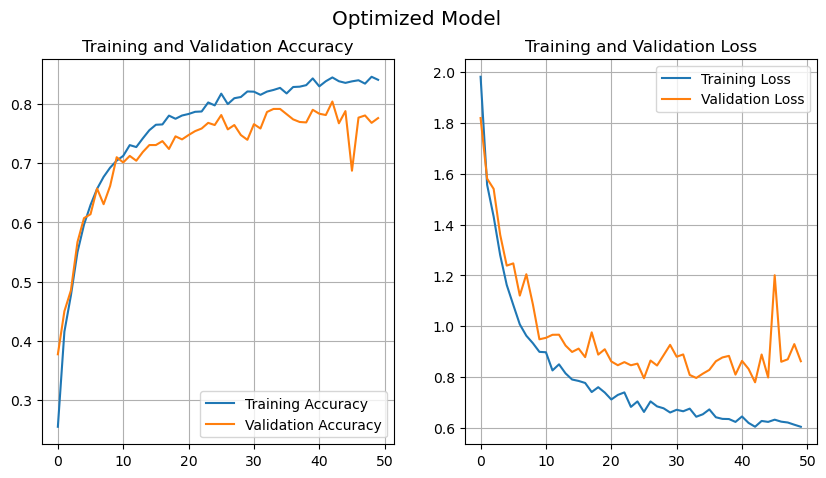

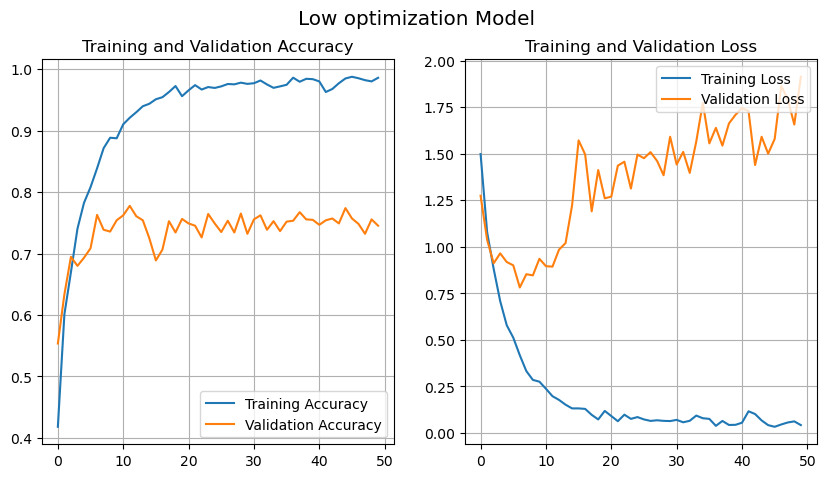

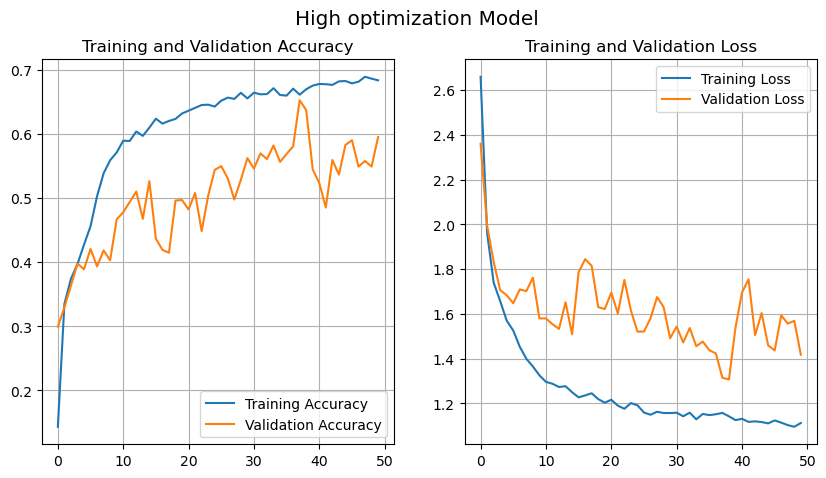

In [164]:
visualize_model(optimized_history, 'Optimized Model')
visualize_model(optimized_low_history, 'Low optimization Model')
visualize_model(optimized_high_history, 'High optimization Model')

### Confusion Matrix

#### Confusion Matrix with "true" normalization

43/43 [==============================] - 1s 15ms/step


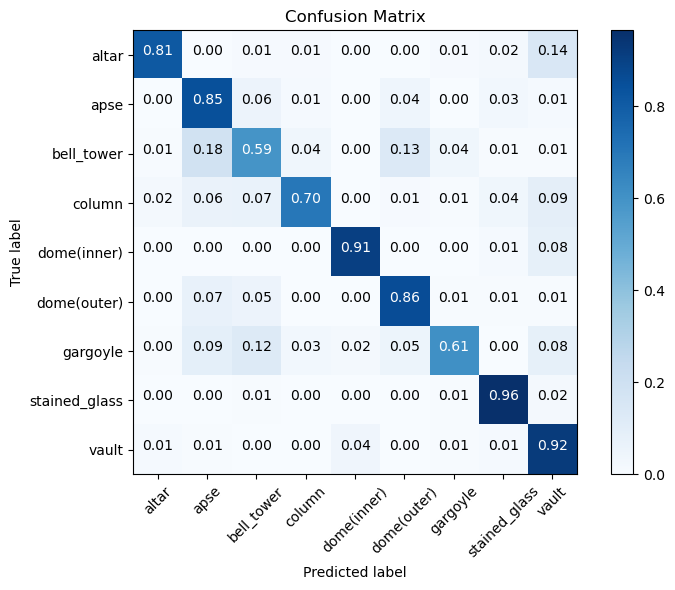

In [165]:
conf_matrix = calculate_confusion_matrix(optimized_model,validation_data, "true")
visualize_confusion_matrix(conf_matrix, color_map='Blues')

#### Confusion Matrix with "pred" normalization

43/43 [==============================] - 1s 18ms/step


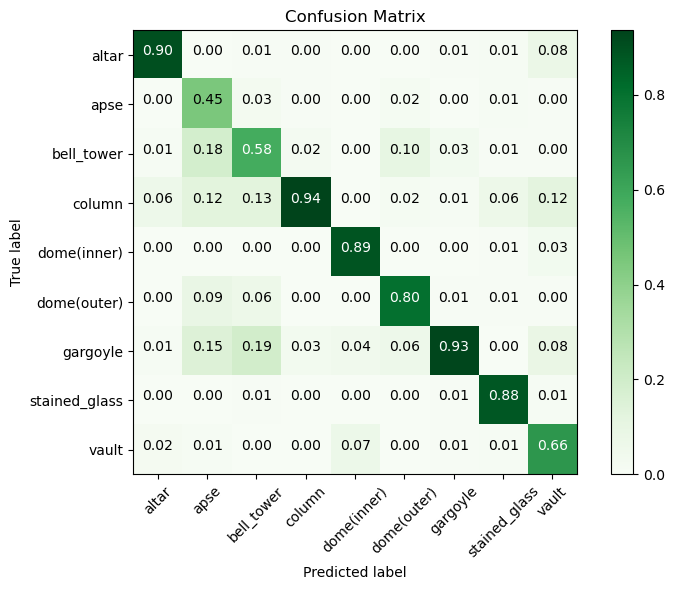

In [166]:
conf_matrix = calculate_confusion_matrix(optimized_model,validation_data, "pred")
visualize_confusion_matrix(conf_matrix, color_map='Greens')

#### Confusion Matrix with "all" normalization

43/43 [==============================] - 1s 14ms/step


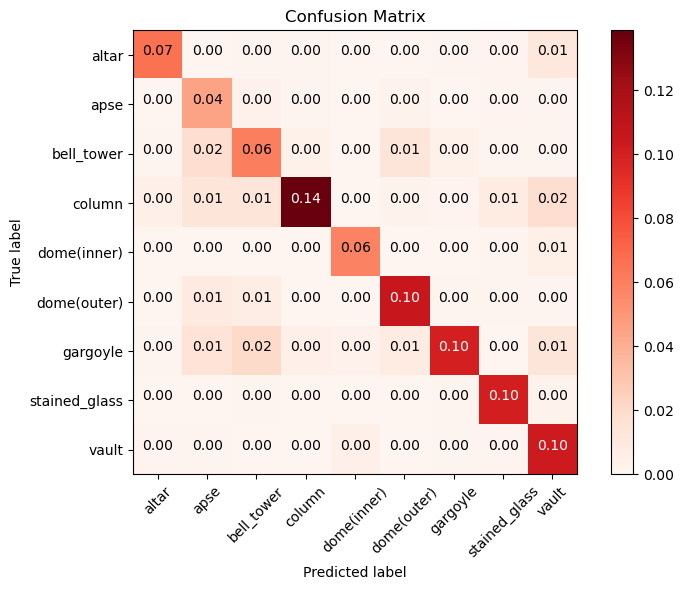

In [167]:
conf_matrix = calculate_confusion_matrix(optimized_model,validation_data, "all")
visualize_confusion_matrix(conf_matrix, color_map='Reds')

### Discussion

## Quantification of the model performance

### s) Classification metrics

In [69]:
def calculate_classification_report(model, v_data=validation_data, normalize=None):   
    true_labels = get_labels(v_data)
    predicted_labels = get_predicted_labels(model, v_data)
    return sk_metrics.classification_report(true_labels, predicted_labels)

print(calculate_classification_report(optimized_model))

12/43 [=======>......................] - ETA: 0s

43/43 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       128
           1       0.44      0.70      0.54        64
           2       0.59      0.39      0.47       163
           3       0.94      0.40      0.56       270
           4       0.45      0.96      0.61        92
           5       0.65      0.73      0.69       156
           6       0.69      0.56      0.62       217
           7       0.95      0.84      0.89       129
           8       0.46      0.71      0.56       143

    accuracy                           0.63      1362
   macro avg       0.65      0.68      0.63      1362
weighted avg       0.70      0.63      0.63      1362



### t) Generalization error (using k-fold CV)

In [ ]:
num_epochs = 10
num_folds = 4

acc_per_fold = []
loss_per_fold = []

k_fold = KFold(n_splits=num_folds, shuffle=True)

## Discussion